In [2]:
from models.merge import CNN, BiLSTM, ELMo, Ensemble
from data.Dataset import Dataset
from data.TrainSet import TrainSet
from utils.utils import plot_words_cloud, plot_words_count, plot_compare_bars

2021-11-21 13:32:47,229 : INFO : Loading model from ./elmo/...
2021-11-21 13:32:47,298 : INFO : We will cache the vocabulary of 100 tokens.
d:\study\pyenvnn\lib\site-packages\simple_elmo\model.py:529: UserWarning: `tf.nn.rnn_cell.LSTMCell` is deprecated and will be removed in a future version. This class is equivalent as `tf.keras.layers.LSTMCell`, and will be replaced by that in Tensorflow 2.0.
  lstm_cell = tf.compat.v1.nn.rnn_cell.LSTMCell(
d:\study\pyenvnn\lib\site-packages\keras\layers\legacy_rnn\rnn_cell_impl.py:984: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  self._kernel = self.add_variable(
d:\study\pyenvnn\lib\site-packages\keras\layers\legacy_rnn\rnn_cell_impl.py:993: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  self._bias = self.add_variable(
d:\study\pyenvnn\lib\site-packages\keras\layers\le

Read books

In [3]:
names = ["Furman", "Garshin"]
dataset = Dataset(names)
dataset.data

,label,author,text
0,0,Furman,﻿П. Р. Фурман\nСаардамский плотник\n \n\n184...
1,1,Garshin,﻿Всеволод Михайлович Гаршин\nНадежда Николаев...


Clean text from punctuation

In [4]:
dataset.preprocess()
dataset.data

Preprocessing Garshin: 100%|██████████| 33664/33664 [00:04<00:00, 7103.59it/s]


,label,author,text
0,0,Furman,фурман саардамский плотник глава незнакомец на...
1,1,Garshin,всеволод михайлович гаршин надежда николаевна ...


VISUALIZING THE DATA

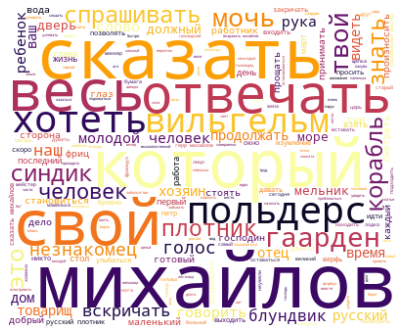

<Figure size 432x288 with 0 Axes>

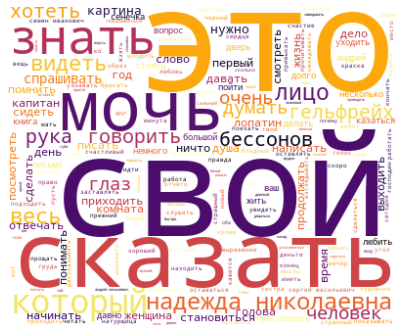

<Figure size 432x288 with 0 Axes>

In [5]:
plot_words_cloud(dataset.data)

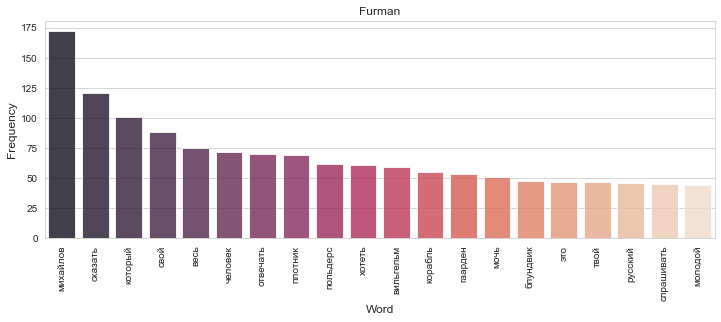

<Figure size 432x288 with 0 Axes>

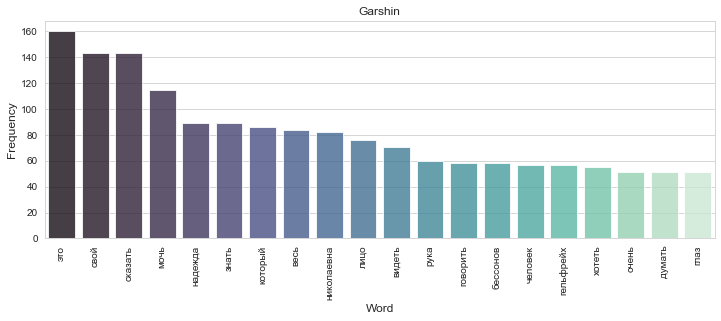

<Figure size 432x288 with 0 Axes>

In [6]:
plot_words_count(dataset.data)

Count and visualize as barplots

d:\study\pyenvnn\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


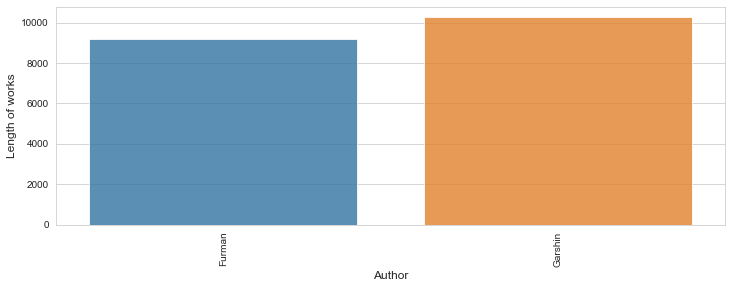

<Figure size 432x288 with 0 Axes>

In [7]:
plot_compare_bars(dataset.data)

In [8]:
dataset.chunking()
dataset.prep_data

,label,author,text
0,0,Furman,"[фурман, саардамский, плотник, глава, незнаком..."
1,0,Furman,"[ровно, набегать, берег, оставлять, каменья, ж..."
2,0,Furman,"[берег, начинать, оживляться, остроконечный, к..."
3,0,Furman,"[черный, масса, полуоконченный, смоленый, судн..."
4,0,Furman,"[узкий, деревянный, лестница, выбеливать, мука..."
...,...,...,...
251,1,Garshin,"[очень, это, жаль, это, рука, надежда, николае..."
252,1,Garshin,"[лицо, глаз, закрывать, неподвижный, чувствова..."
253,1,Garshin,"[оставлять, последний, сила, подымать, полагат..."
254,1,Garshin,"[прибавлять, соня, приезжать, вызывать, телегр..."


In [9]:
dataset.embedding(ELMo)

2021-11-21 13:33:19,858 : INFO : Warming up ELMo on 40 sentences...
2021-11-21 13:33:29,375 : INFO : Warming up finished.
2021-11-21 13:33:29,380 : INFO : Texts in the current batch: 40
2021-11-21 13:33:29,507 : INFO : Texts in the current batch: 40
2021-11-21 13:33:29,632 : INFO : Texts in the current batch: 40
2021-11-21 13:33:29,750 : INFO : Texts in the current batch: 40
2021-11-21 13:33:29,867 : INFO : Texts in the current batch: 40
2021-11-21 13:33:29,980 : INFO : Texts in the current batch: 29
2021-11-21 13:33:36,031 : INFO : Warming up ELMo on 40 sentences...
2021-11-21 13:33:36,699 : INFO : Warming up finished.
2021-11-21 13:33:36,705 : INFO : Texts in the current batch: 40
2021-11-21 13:33:36,828 : INFO : Texts in the current batch: 40
2021-11-21 13:33:36,947 : INFO : Texts in the current batch: 40
2021-11-21 13:33:37,063 : INFO : Texts in the current batch: 40
2021-11-21 13:33:37,183 : INFO : Texts in the current batch: 40
2021-11-21 13:33:37,301 : INFO : Texts in the curren

(485,)

In [10]:
dataset.prep_data

,label,author,text,embeddings
0,0,Furman,"[фурман, саардамский, плотник, глава, незнаком...","[[0.05089219659566879, -0.4667363166809082, -0..."
1,0,Furman,"[ровно, набегать, берег, оставлять, каменья, ж...","[[-0.163458451628685, 0.38956519961357117, 0.0..."
2,0,Furman,"[берег, начинать, оживляться, остроконечный, к...","[[-0.26216450333595276, 0.17301079630851746, 0..."
3,0,Furman,"[черный, масса, полуоконченный, смоленый, судн...","[[0.30254673957824707, -0.3684810996055603, -0..."
4,0,Furman,"[узкий, деревянный, лестница, выбеливать, мука...","[[0.745839536190033, 0.10881125926971436, 0.84..."
...,...,...,...,...
251,1,Garshin,"[очень, это, жаль, это, рука, надежда, николае...","[[-0.15288180112838745, -0.5249289274215698, -..."
252,1,Garshin,"[лицо, глаз, закрывать, неподвижный, чувствова...","[[0.36640477180480957, -0.1638725847005844, -0..."
253,1,Garshin,"[оставлять, последний, сила, подымать, полагат...","[[0.36951661109924316, 0.1000952273607254, 0.4..."
254,1,Garshin,"[прибавлять, соня, приезжать, вызывать, телегр...","[[0.00957345962524414, 0.5480434894561768, 0.3..."


In [11]:
train_set = TrainSet(dataset.prep_data)
train_set.shape

,Train,Test,Val
X,"(350, 40, 1024)","(73, 40, 1024)","(62, 40, 1024)"
Y,"(350, 3)","(73, 3)","(62, 3)"


In [12]:
cnn = CNN(train_set.X_shape(), output_units=3)
cnn.build()

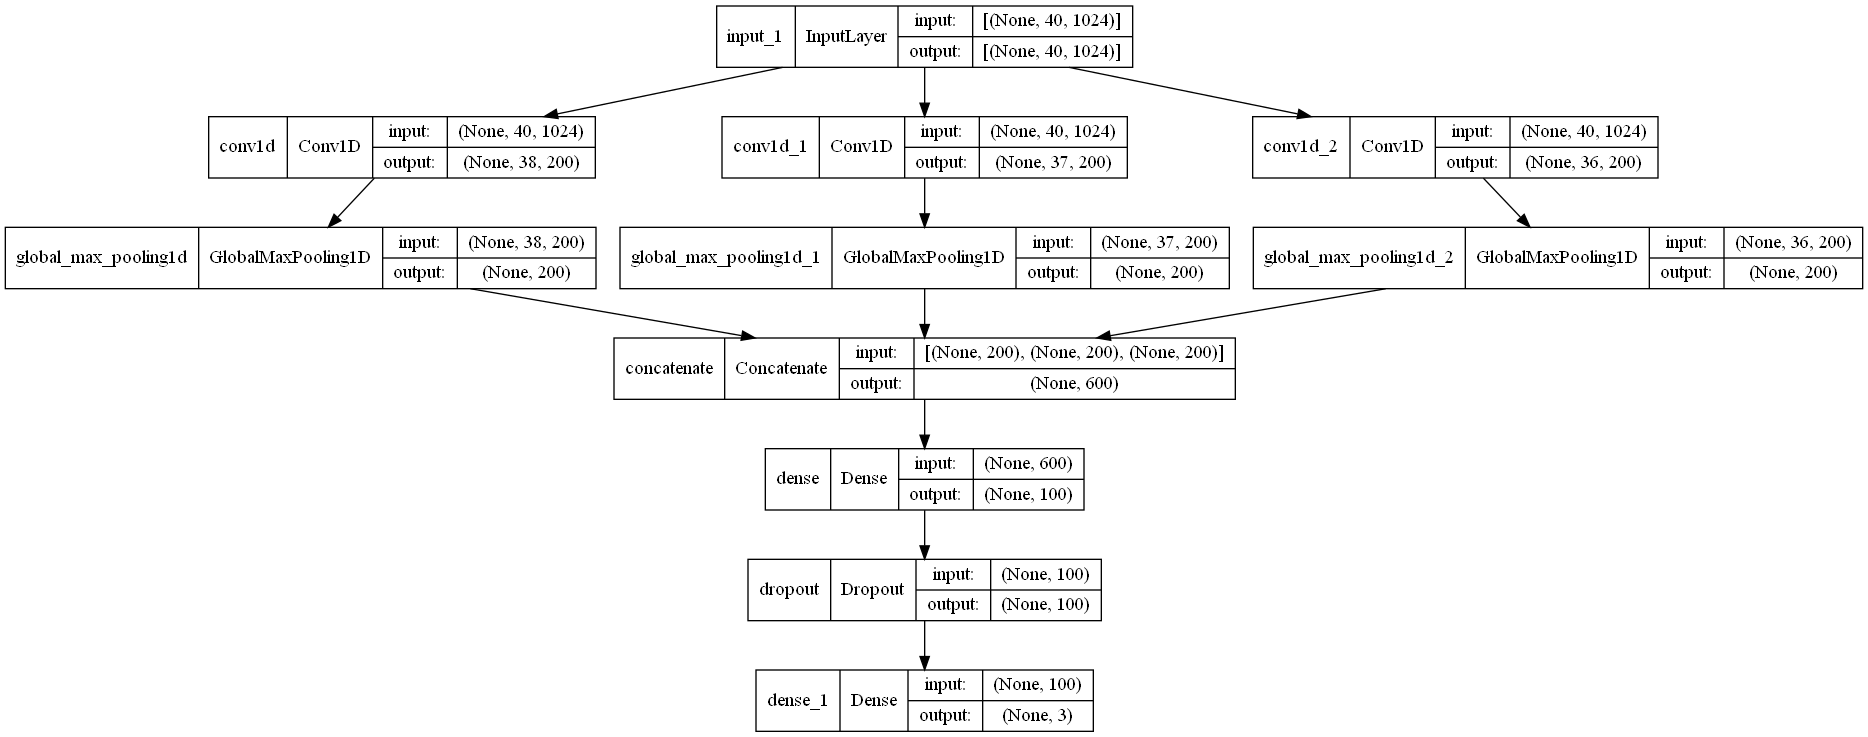

In [13]:
cnn.plot_model()

Train on 350 samples, validate on 62 samples
Epoch 1/10


d:\study\pyenvnn\lib\site-packages\keras\engine\training_v1.py:2057: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


350/350 - 2s - loss: 1.1992 - accuracy: 0.6000 - val_loss: 0.0986 - val_accuracy: 0.9516 - 2s/epoch - 7ms/sample
Epoch 2/10
350/350 - 0s - loss: 0.2167 - accuracy: 0.9143 - val_loss: 0.0488 - val_accuracy: 0.9839 - 111ms/epoch - 318us/sample
Epoch 3/10
350/350 - 0s - loss: 0.1717 - accuracy: 0.9457 - val_loss: 0.0556 - val_accuracy: 0.9677 - 112ms/epoch - 319us/sample
Epoch 4/10
350/350 - 0s - loss: 0.0880 - accuracy: 0.9629 - val_loss: 0.0238 - val_accuracy: 1.0000 - 110ms/epoch - 313us/sample
Epoch 5/10
350/350 - 0s - loss: 0.0286 - accuracy: 0.9914 - val_loss: 0.0207 - val_accuracy: 1.0000 - 112ms/epoch - 319us/sample
Epoch 6/10
350/350 - 0s - loss: 0.0214 - accuracy: 0.9914 - val_loss: 0.0214 - val_accuracy: 0.9839 - 109ms/epoch - 311us/sample
Epoch 7/10
350/350 - 0s - loss: 0.0211 - accuracy: 0.9914 - val_loss: 0.0061 - val_accuracy: 1.0000 - 111ms/epoch - 316us/sample
Epoch 8/10
350/350 - 0s - loss: 0.0250 - accuracy: 0.9914 - val_loss: 0.0150 - val_accuracy: 1.0000 - 109ms/epoch

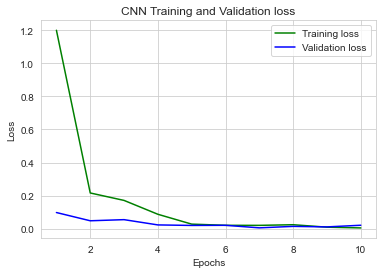

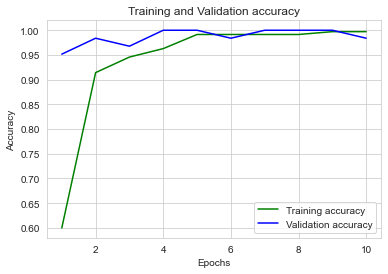

<Figure size 432x288 with 0 Axes>

In [14]:
cnn.fit(train_set)

In [15]:
bilstm = BiLSTM(train_set.X_shape(), hidden_state_dim=500)

In [16]:
bilstm.build()

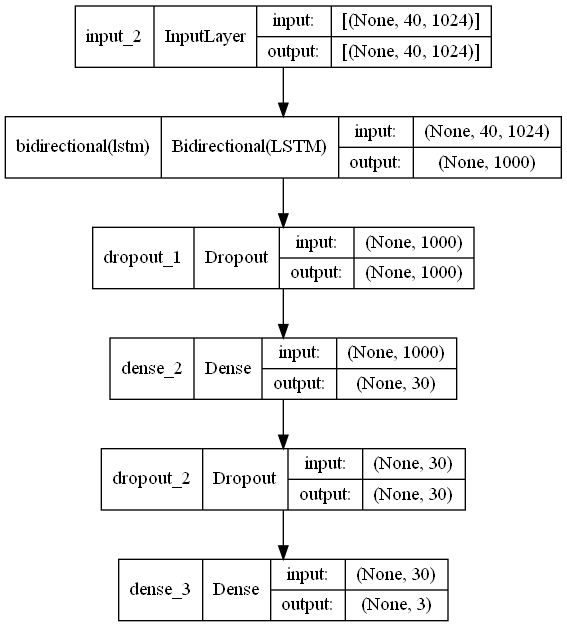

In [17]:
bilstm.plot_model()

Train on 350 samples, validate on 62 samples
Epoch 1/10
350/350 - 1s - loss: 0.6546 - accuracy: 0.7000 - val_loss: 0.1243 - val_accuracy: 0.9677 - 1s/epoch - 4ms/sample
Epoch 2/10
350/350 - 1s - loss: 0.1654 - accuracy: 0.9486 - val_loss: 0.0539 - val_accuracy: 0.9839 - 548ms/epoch - 2ms/sample
Epoch 3/10
350/350 - 0s - loss: 0.0610 - accuracy: 0.9686 - val_loss: 0.1427 - val_accuracy: 0.9355 - 490ms/epoch - 1ms/sample
Epoch 4/10
350/350 - 0s - loss: 0.0339 - accuracy: 0.9857 - val_loss: 0.0545 - val_accuracy: 0.9839 - 497ms/epoch - 1ms/sample
Epoch 5/10
350/350 - 1s - loss: 0.0321 - accuracy: 0.9914 - val_loss: 0.0484 - val_accuracy: 0.9839 - 551ms/epoch - 2ms/sample
Epoch 6/10
350/350 - 1s - loss: 0.0181 - accuracy: 0.9971 - val_loss: 0.0239 - val_accuracy: 1.0000 - 542ms/epoch - 2ms/sample
Epoch 7/10
350/350 - 1s - loss: 0.0075 - accuracy: 1.0000 - val_loss: 0.0612 - val_accuracy: 0.9516 - 538ms/epoch - 2ms/sample
Epoch 8/10
350/350 - 1s - loss: 0.0028 - accuracy: 1.0000 - val_loss:

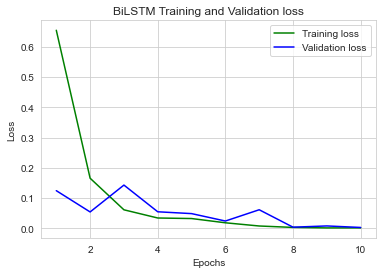

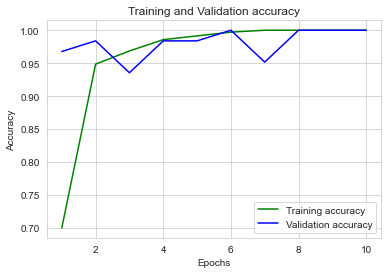

<Figure size 432x288 with 0 Axes>

In [18]:
bilstm.fit(train_set)

In [19]:
cnn_bilstm = Ensemble(cnn, bilstm, train_set)

Train on 350 samples
Epoch 1/10
350/350 [==============================] - 0s 907us/sample - loss: 0.0738 - accuracy: 0.9686
Epoch 2/10
350/350 [==============================] - 0s 371us/sample - loss: 0.0658 - accuracy: 0.9829
Epoch 3/10
350/350 [==============================] - 0s 349us/sample - loss: 0.0432 - accuracy: 0.9857

In [20]:
cnn_bilstm.fit()

d:\study\pyenvnn\lib\site-packages\mlxtend\classifier\ensemble_vote.py:166: UserWarning: fit_base_estimators=False enforces use_clones to be `False`
  warnings.warn("fit_base_estimators=False "


In [21]:
cnn_bilstm.predict()

Using Testing Set for Classes Prediction


d:\study\pyenvnn\lib\site-packages\keras\engine\training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


In [22]:
from data.TestSet import TestSet
from utils.constants import BOOKS_DIR

path = f"{BOOKS_DIR}/Sholokhov/and-quiet-flows-the-don.txt"
testing = TestSet(path, names, ELMo)

Embeddings loaded successfully


In [27]:
import numpy as np

print("test")
#testing.preds = cnn_bilstm.predict(np.array(list(testing.dataframe['embeddings'])))
testing.preds = np.array(cnn_bilstm.voting.predict(np.array(list(testing.dataframe['embeddings']))), dtype='uint8')
testing.plot_prediction()

test


KeyboardInterrupt: 

d:\study\pyenvnn\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


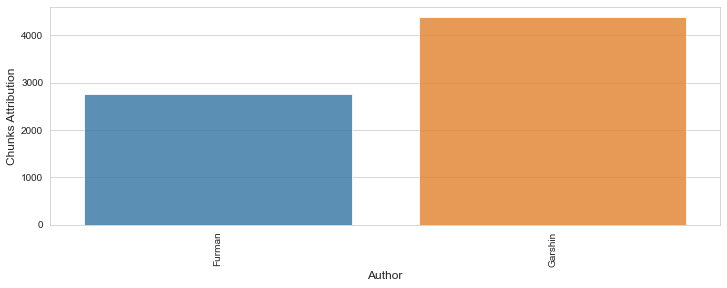

<Figure size 432x288 with 0 Axes>

In [28]:
from matplotlib import pyplot as plt
import seaborn as sns
cnts = [len(np.where(testing.preds == i)[0]) for i in range(2)]
fig = plt.figure(figsize=(12, 4))
fig.set_facecolor('white')

sns.barplot(testing.labels, cnts, alpha=0.8)
plt.ylabel('Chunks Attribution', fontsize=12)
plt.xlabel('Author', fontsize=12)
plt.xticks(rotation=90)
plt.show()
plt.savefig(f"./plots/{testing.author}_{testing.work}.png")

In [ ]:
from mlxtend.plotting import plot_decision_regions

plot_decision_regions(X=testtin, y=y, clf=cnn_bilstm.voting)